In [3]:
#Attempt to find a way to find a top and bottom signal for btc

import numpy as np
import scipy.stats as stats
from datetime import datetime, timedelta
import pandas as pd
import vectorbt as vbt
import matplotlib.pyplot as plt

In [45]:
price = vbt.YFData.download('EURUSD=X', start = '2016-01-01').get('Close')


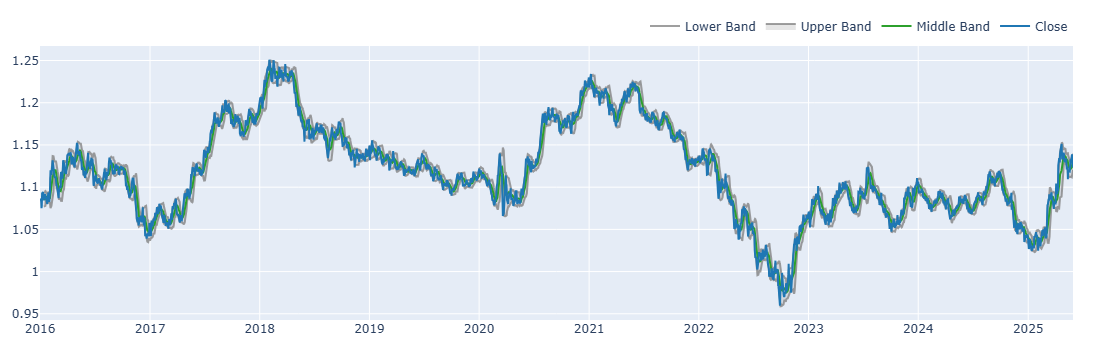

FigureWidget({
    'data': [{'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': '9bf2b995-2ad4-4251-9880-9bc2367983b8',
              'x': array([datetime.datetime(2016, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2016, 1, 4, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2016, 1, 5, 0, 0, tzinfo=datetime.timezone.utc), ...,
                          datetime.datetime(2025, 5, 27, 23, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2025, 5, 28, 23, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2025, 5, 29, 23, 0, tzinfo=datetime.timezone.utc)],
                         dtype=object),
              'y': array([1.08590603, 1.08539915, 1.08275497, ..., 1.13370979, 1.12336826,
                          1.13507378])},
             {'line': {'color': '#1f77b4'},
              'name': 'Close',
         

In [66]:
# Finally see what the total returns are 
# Currently long only

# Calculate Bollinger Bands using vectorbt
bb = vbt.BBANDS.run(price, window = 10, alpha = 1.5) # std is alpha
# Access the bands
upper_band = bb.upper
lower_band = bb.lower
middle_band = bb.middle


# Generate entry signals when fast MA crosses above slow MA
entries = bb.lower_crossed_below(price)  #When price is moving above lower bollinger
short_entries = bb.upper_crossed_above(price)  #When price is moving below upper bollinger

#Make sure entries are mutually exclusive

# Generate exit signals when fast MA crosses below slow MA and short exits for visa versa
exits = bb.middle_crossed_below(price)  # bb.upper_crossed_above(price)  bb.middle_crossed_above(price)
short_exits = bb.middle_crossed_above(price) #& bb.upper_crossed_above(price)) # Primary exit condition # Safety exit if price revisits upper band 


# Run the backtest and return the Sharpe ratio
pf = vbt.Portfolio.from_signals(price, entries, exits, short_entries, short_exits) #, short_entries, short_exits)

# Plot trades

fig = price.vbt.plot(trace_kwargs=dict(name='Close'))
bb.plot().show()
pf.positions.plot(close_trace_kwargs=dict(visible=False), fig=fig)



In [67]:
pf.stats()

C:\Python_Folder\pyproj\my_env2\Lib\site-packages\vectorbt\generic\stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

C:\Python_Folder\pyproj\my_env2\Lib\site-packages\vectorbt\generic\stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

C:\Python_Folder\pyproj\my_env2\Lib\site-packages\vectorbt\generic\stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

C:\Python_Folder\pyproj\my_env2\Lib\site-packages\vectorbt\generic\stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2016-01-01 00:00:00+00:00
End                           2025-05-29 23:00:00+00:00
Period                                             2450
Start Value                                       100.0
End Value                                    109.277324
Total Return [%]                               9.277324
Benchmark Return [%]                           4.527809
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                               10.98676
Max Drawdown Duration                             707.0
Total Trades                                        201
Total Closed Trades                                 201
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  66.169154
Best Trade [%]                                 2.635003
Worst Trade [%]                               -4

In [53]:
split_kwargs = dict(
    n=30, 
    window_len=365 * 2, 
    set_lens=(180,), 
    left_to_right=False
)  # 30 windows, each 2 years long, reserve 180 days for test
pf_kwargs = dict(
    direction='both',  # long and short
    freq='d'
)
windows = np.arange(1, 50)

In [8]:
def roll_in_and_out_samples(price, **kwargs):
    return price.vbt.rolling_split(**kwargs)

In [9]:
roll_in_and_out_samples(price, **split_kwargs, plot=True, trace_names=['in-sample', 'out-sample']).show()


C:\Python_Folder\pyproj\my_env2\Lib\site-packages\jupyter_client\session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant: nan
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant

C:\Python_Folder\pyproj\my_env2\Lib\site-packages\jupyter_client\session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant: nan
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



In [10]:
(in_price, in_indexes), (out_price, out_indexes) = roll_in_and_out_samples(price, **split_kwargs)

print(in_price.shape, len(in_indexes))  # in-sample
print(out_price.shape, len(out_indexes))  # out-sample

(550, 30) 30
(180, 30) 30


In [11]:
def simulate_all_params(price, windows, **kwargs):
    upper_band, lower_band, middle_band = vbt.BBANDS.run_combs(price, windows, r=3, short_names=['upper_band','lower_band','middle_band'])
    entries = bb.lower_crossed_below(price) 
    exits = bb.middle_crossed_above(price)
    pf = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return pf.sharpe_ratio()

print("windows:", windows) 
print("upper_band shape:", upper_band.shape)  # Inspect shape of bands
print("price shape:", price.shape)  # Shape of price data

windows: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49]
upper_band shape: (3323,)
price shape: (3323,)


In [12]:
# Simulate all params for in-sample ranges
in_sharpe = simulate_all_params(in_price, windows, **pf_kwargs)

print(in_sharpe)


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3323, 1) and arg 1 with shape (550, 30).

In [ ]:
# Find best params
def get_best_index(performance, higher_better=True):
    if higher_better:
        return performance[performance.groupby('split_idx').idxmax()].index
    return performance[performance.groupby('split_idx').idxmin()].index

in_best_index = get_best_index(in_sharpe)

print(in_best_index)

def get_best_params(best_index, level_name):
    return best_index.get_level_values(level_name).to_numpy()

in_best_upper_band = get_best_params(in_best_index, 'upper_band')
in_best_lower_band = get_best_params(in_best_index, 'lower_band')
in_best_middle_band = get_best_params(in_best_index, 'middle_band')
in_best_window_pairs = np.array(list(zip(in_best_upper_band, in_best_lower_band, in_best_middle_band)))

print(in_best_window_pairs)

pd.DataFrame(in_best_window_pairs, columns=['upper_band', 'lower_band', 'middle_band' ]).vbt.plot().show()

out_hold_sharpe = simulate_holding(out_price, **pf_kwargs)

print(out_hold_sharpe)

# Simulate all params for out-sample ranges
out_sharpe = simulate_all_params(out_price, windows, **pf_kwargs)

print(out_sharpe)

def simulate_best_params(price, best_upper, best_lower, best_middle, **kwargs):
    upper = vbt.BBANDS.run(price, window =best_upper, per_column=True)
    lower = vbt.BBANDS.run(price, window=best_lower, per_column=True)
    middle = vbt.BBANDS.run(price, window=best_middle, per_column=True)
    entries = bb.lower_crossed_below(price) 
    exits = bb.middle_crossed_above(price)
    pf = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    return pf.sharpe_ratio()

# Use best params from in-sample ranges and simulate them for out-sample ranges
out_test_sharpe = simulate_best_params(out_price, in_best_upper_band, in_best_lower_band, in_best_middle_band, **pf_kwargs)

print(out_test_sharpe)